### 本文档解决的问题是：
### 不同分布地点的加工厂分别与什么变量的关系更大
### 首先通过相关性分析去掉共线变量

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon
from shapely.geometry import box
import analysis_tool as tool

In [13]:
gdfs = tool.load_all_gdfs("origin_data")

✅  已加载 00_Boundaries: Whole area.shp (1 条记录, 0.08 MB)
✅  已加载 01_production_farming: farming.shp (1647 条记录, 2.90 MB)
✅  已加载 02_production_aquaculture: aquaculture.shp (211 条记录, 2.49 MB)
✅  已加载 03_production_livestock: livestock.shp (1538 条记录, 1.61 MB)
✅  已加载 04_transformation_industry: processing.shp (58 条记录, 0.00 MB)
✅  已加载 05_transformation_energy: energy.shp (147 条记录, 0.03 MB)
✅  已加载 06_logistics_transportation: transportation.shp (656 条记录, 0.28 MB)
✅  已加载 07_logistics_roads: roads_highways.shp (58252 条记录, 6.92 MB)
✅  已加载 08_supply_retail: shop_food_beverage_data.shp (432 条记录, 0.01 MB)
✅  已加载 09_supply_public_services: public_services.shp (911 条记录, 0.02 MB)
✅  已加载 10_built_environment: buildings.shp (189600 条记录, 54.22 MB)
✅  已加载 11_consumption_facilities: consumption_data.shp (2889 条记录, 0.08 MB)
✅  已加载 12_consumption_landuse_mix: landuse_mix.shp (7124 条记录, 2.28 MB)
✅  已加载 13_waste_treatment: impianti_smaltimento_rifiuti.shp (10 条记录, 0.00 MB)


In [ ]:
def create_square_patch(center_point, half_size):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

# 创建 patch GeoDataFrame
patch_size = 500  # 半径500m → patch大小为1000m×1000m
patches = gdfs["04_transformation_industry"].copy()
patches["geometry"] = patches.geometry.apply(lambda pt: create_square_patch(pt, patch_size))
patches.reset_index(drop=True, inplace=True)
print(patches)
patches.to_file("processing_data\patch\patches_1000.geojson")

In [ ]:
# 空间连接，储存为 joined_patches
grid = gpd.read_file("processing_data\patch\patches_1000.geojson")
# 计算面
grid = tool.area_polygons_in_grid(gdfs["01_production_farming"], grid, "farming_area")
grid = tool.area_polygons_in_grid(gdfs["02_production_aquaculture"], grid, "aquaculture_area")
grid = tool.area_polygons_in_grid(gdfs["03_production_livestock"], grid, "pasture_area")
grid = tool.area_polygons_in_grid(gdfs["05_transformation_energy"], grid, "energy_area")
grid = tool.area_polygons_in_grid(gdfs["06_logistics_transportation"], grid, "transportation_area")
grid = tool.area_polygons_in_grid(gdfs["10_built_environment"], grid, "built_area")
grid = tool.area_polygons_in_grid(gdfs["12_consumption_landuse_mix"], grid, "landuse_area")
# 计算各个landuse
gdf_landuse=gdfs["12_consumption_landuse_mix"]
landuse_types = gdf_landuse["landuse"].unique()
for landuse_type in landuse_types:
    sub_gdf = gdf_landuse[gdf_landuse["landuse"] == landuse_type]
    column_name = f"{landuse_type}_area"
    grid = tool.area_polygons_in_grid(sub_gdf, grid, column_name)
# 计算点
# grid = tool.count_points_in_grid(gdfs["04_transformation_industry"], grid, "factory_count")
grid = tool.count_points_in_grid(gdfs["08_supply_retail"], grid, "retail_count")
grid = tool.count_points_in_grid(gdfs["09_supply_public_services"], grid, "public_services")
grid = tool.count_points_in_grid(gdfs["11_consumption_facilities"], grid, "consumption_count")
grid = tool.count_points_in_grid(gdfs["13_waste_treatment"], grid, "waste_treatment")
# 计算线
grid = tool.length_lines_in_grid(gdfs["07_logistics_roads"], grid, "road_length")
# 道路交叉点
gdf_intersections = tool.extract_road_intersections(gdfs["07_logistics_roads"])
grid = tool.count_points_in_grid(gdf_intersections, grid, "intersection_count")
# 其他
grid.to_file("processing_data\patch\joined_patches_1000.geojson")

In [ ]:
# 归一化，存储成
from sklearn.preprocessing import MinMaxScaler
import numpy as np


joined_grid= gpd.read_file("processing_data\patch\joined_patches_1000.geojson")

cols_to_normalize = [
       'farming_area', 'pasture_area', 'energy_area',
       'transportation_area', 'landuse_area', 'farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area', 'retail_count', 'public_services',
       'consumption_count', 'waste_treatment', 'road_length',
       'intersection_count', 'aquaculture_area', 'built_area'
]
# 归一化
scaler = MinMaxScaler()
grid[[f"{col}_norm" for col in cols_to_normalize]] = scaler.fit_transform(joined_grid[cols_to_normalize])

# 计算农业混合度
production_cols = ['farming_area','aquaculture_area','pasture_area']
norm_cols = [f"{col}_norm" for col in production_cols]
def shannon_entropy_production(row):
    p = row[norm_cols].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_production'] = grid.apply(shannon_entropy_production, axis=1)
# 计算用地混合度
landuse_cols = ['farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area']
norm_cols_2 = [f"{col}_norm" for col in landuse_cols]
def shannon_entropy_landuse(row):
    p = row[norm_cols_2].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_landuse'] = grid.apply(shannon_entropy_landuse, axis=1)
print(grid.columns)
# grid = grid[['grid_id','geometry', 'farming_area_norm','aquaculture_area_norm',
#        'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
#        'factory_count_norm', 'retail_count_norm', 'public_services_norm',
#        'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
#        'intersection_count_norm','built_area_norm',
#        'entropy_production', 'entropy_landuse' ]]
grid = grid[['geometry', 'farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse' ]]
grid.to_file("processing_data\patch\patches_normalized_1000.geojson")

In [ ]:
# 热力图

patches_map = gpd.read_file("processing_data\patch\patches_normalized_1000.geojson")

variables = ['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']

fig, axs = plt.subplots(4,3, figsize=(10,8))
axs = axs.flatten()
for i, var in enumerate(variables):
    patches_map.plot(column=var, ax=axs[i], cmap='OrRd', legend=True, edgecolor='grey', linewidth=0.2)
    axs[i].set_title(f'{var} per Grid', fontsize=5)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

      farming_area_norm  aquaculture_area_norm  pasture_area_norm  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   
3                   0.0                    0.0                0.0   
4                   0.0                    0.0                0.0   
...                 ...                    ...                ...   
3871                0.0                    0.0                0.0   
3872                0.0                    0.0                0.0   
3873                0.0                    0.0                0.0   
3874                0.0                    0.0                0.0   
3875                0.0                    0.0                0.0   

      energy_area_norm  transportation_area_norm  retail_count_norm  \
0                  0.0                       0.0                0.0   
1                  0.0       

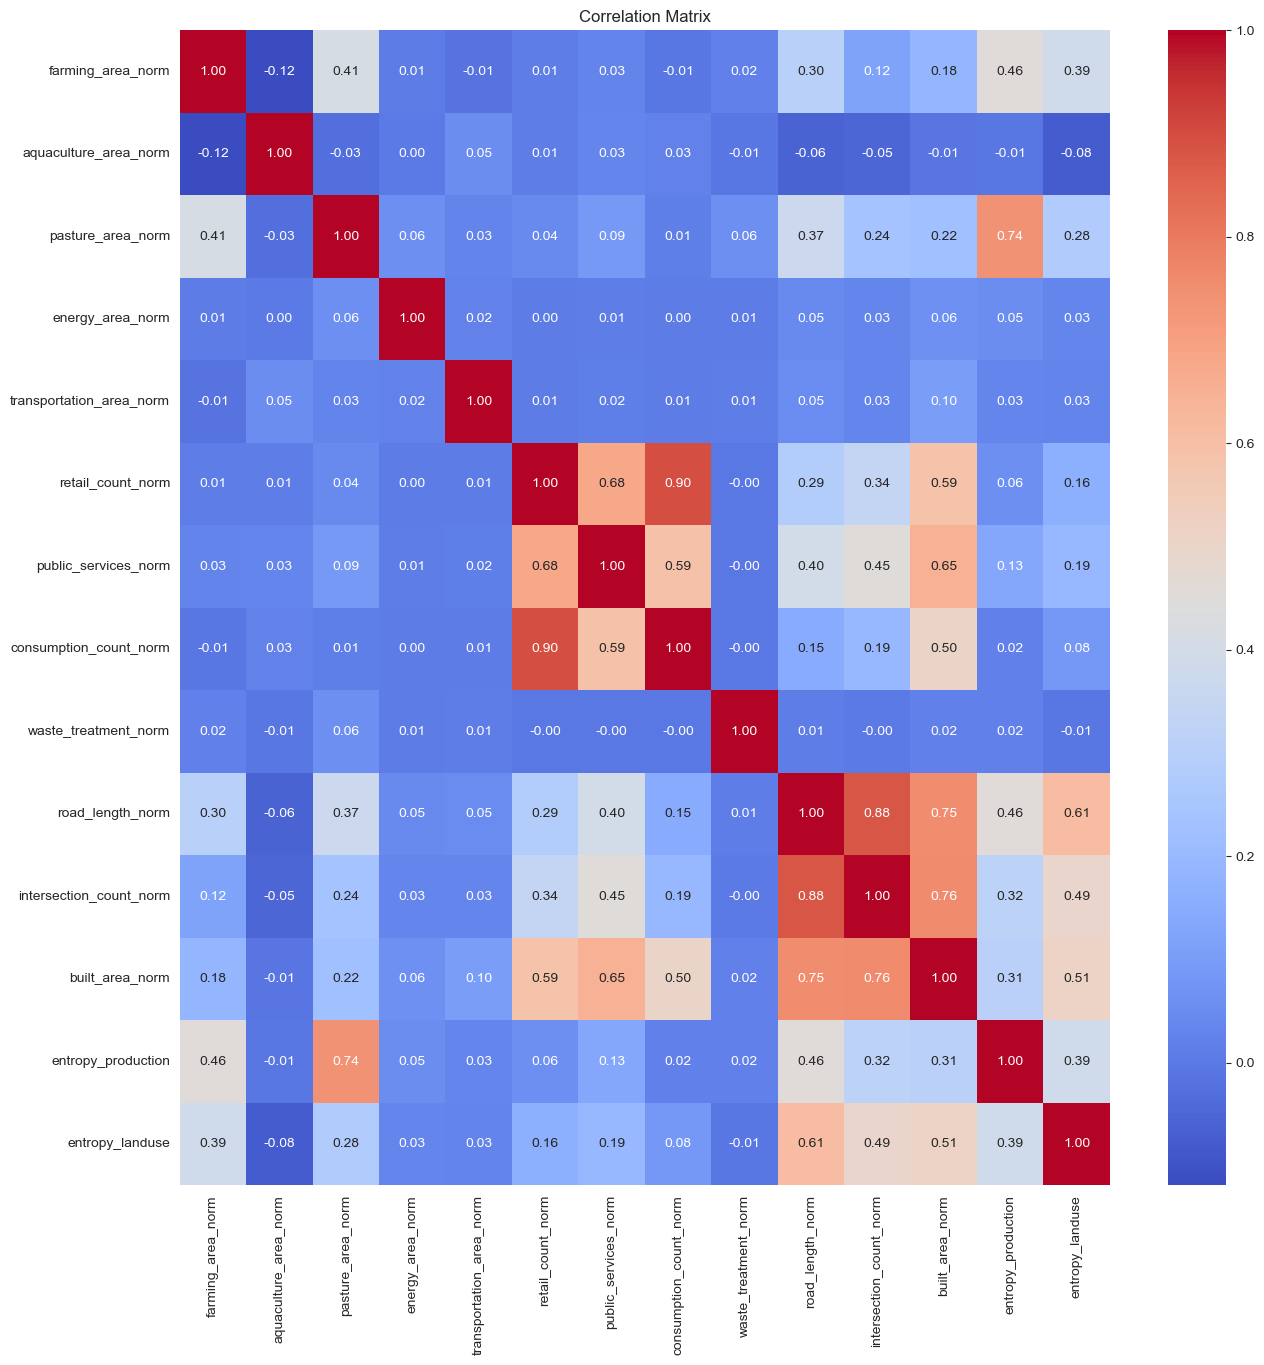

In [15]:
import seaborn as sns
import pandas as pd
patches = gpd.read_file("processing_data\grid\grid_normalized.geojson")

# 只提取需要分析的字段
df_analysis = patches[['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np

# 标准化变量（非必须但推荐）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis.dropna())  # 去除 NaN 影响

# 重新构建为 DataFrame
X_df = pd.DataFrame(X_scaled, columns=df_analysis.columns)

# 计算 VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X_df.columns
vif_df["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

# vif_df.to_csv("vif_result.csv", index=False)
print(vif_df)

# 根据结论：
# consumption_count 与 retail_count，public_services， built_area
#

                    Variable       VIF
0          farming_area_norm  1.502820
1      aquaculture_area_norm  1.028929
2          pasture_area_norm  2.287177
3           energy_area_norm  1.010792
4   transportation_area_norm  1.030786
5          retail_count_norm  6.519733
6       public_services_norm  2.311633
7     consumption_count_norm  5.821326
8       waste_treatment_norm  1.007129
9           road_length_norm  6.720643
10   intersection_count_norm  5.644349
11           built_area_norm  4.673453
12        entropy_production  2.564118
13           entropy_landuse  1.810429


#  GWR分析
## 在进行分析之前，首先有OLS回归模型的分析

In [17]:
# patches = gpd.read_file("processing_data/patch/patches_normalized_1000.geojson")
patches = gpd.read_file("processing_data\grid\grid_normalized.geojson")
print(patches.columns)

Index(['grid_id', 'farming_area_norm', 'aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm', 'built_area_norm', 'entropy_production',
       'entropy_landuse', 'geometry'],
      dtype='object')


In [28]:
import geopandas as gpd
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# === 1. 加载数据 ===
patches = gpd.read_file("processing_data\grid\grid_normalized.geojson")
print(patches.columns)
# === 2. 选择变量 & 去除共线变量 ===
selected_vars = ['farming_area_norm','aquaculture_area_norm','pasture_area_norm','energy_area_norm',
                 'transportation_area_norm','retail_count_norm','public_services_norm',
                 'road_length_norm','built_area_norm','entropy_production','entropy_landuse']
X_raw = patches[selected_vars].dropna()
y = patches['factory_count_norm'].values.reshape(-1, 1) # 替换为你真实的目标变量列名
# y = np.ones((X_raw.shape[0], 1))
# === 3. 标准化变量（推荐） ===
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
# y = y.values.reshape(-1, 1)

# === 4. OLS 回归 ===
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print("=== OLS 模型结果 ===")
print(ols_model.summary())

# === 5. GWR 准备坐标 ===
# coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in patches.loc[X_raw.index].geometry])
coords = np.array([[geom.x, geom.y] for geom in  patches.geometry.centroid])

# === 6. 选择最优带宽 ===
selector = Sel_BW(coords, y, X)
bw = selector.search(bw_min=2, bw_max=100)
print(f"✅ GWR 最优带宽: {bw}")

# === 7. 拟合 GWR 模型 ===
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# # === 8. 输出比较指标 ===
# print("\n=== 模型指标对比 ===")
# print(f"GWR AICc : {gwr_results.AICc:.4f}")
# print(f"OLS AIC  : {ols_model.aic:.4f}")
# print(f"GWR R2   : {gwr_results.R2:.4f}")
# print(f"OLS R2   : {ols_model.rsquared:.4f}")

# === 9. 输出每个点的回归系数表 ===
beta_df = pd.DataFrame(gwr_results.params, columns=["Intercept"] + selected_vars)
beta_df["R2_local"] = gwr_results.localR2
beta_df.to_csv("gwr_coefficients.csv", index=False)

# === 10. 若需要合并到 GeoDataFrame 可视化 ===
patches_gwr = patches.loc[X_raw.index].copy()
for i, var in enumerate(["Intercept"] + selected_vars):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]
patches_gwr["R2_local"] = gwr_results.localR2
patches_gwr.to_file("patches_with_gwr.shp")  # 或保存为 GeoJSON
print(patches_gwr.columns)

Index(['grid_id', 'farming_area_norm', 'aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm', 'built_area_norm', 'entropy_production',
       'entropy_landuse', 'geometry'],
      dtype='object')
=== OLS 模型结果 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     37.50
Date:                Sat, 31 May 2025   Prob (F-statistic):           2.48e-77
Time:                        15:52:34   Log-Likelihood:                 6704.8
No. Observations:                3876   AIC:                        -1.339e+04
Df 

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\mgwr\gwr.py:775: RuntimeWarning: divide by zero encountered in divide
  return (self.TSS - self.RSS) / self.TSS
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\mgwr\gwr.py:775: RuntimeWarning: invalid value encountered in divide
  return (self.TSS - self.RSS) / self.TSS
C:\Users\Elena\AppData\Local\Temp\ipykernel_13616\1057308515.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  patches_gwr.to_file("patches_with_gwr.shp")  # 或保存为 GeoJSON
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'farming_area_norm' to 'farming_ar'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'aquaculture_area_norm' to 'aquacultur'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.

Index(['grid_id', 'farming_area_norm', 'aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm', 'built_area_norm', 'entropy_production',
       'entropy_landuse', 'geometry', 'beta_Intercept',
       'beta_farming_area_norm', 'beta_aquaculture_area_norm',
       'beta_pasture_area_norm', 'beta_energy_area_norm',
       'beta_transportation_area_norm', 'beta_retail_count_norm',
       'beta_public_services_norm', 'beta_road_length_norm',
       'beta_built_area_norm', 'beta_entropy_production',
       'beta_entropy_landuse', 'R2_local'],
      dtype='object')


D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\mgwr\gwr.py:775: RuntimeWarning: divide by zero encountered in divide
  return (self.TSS - self.RSS) / self.TSS
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\mgwr\gwr.py:775: RuntimeWarning: invalid value encountered in divide
  return (self.TSS - self.RSS) / self.TSS


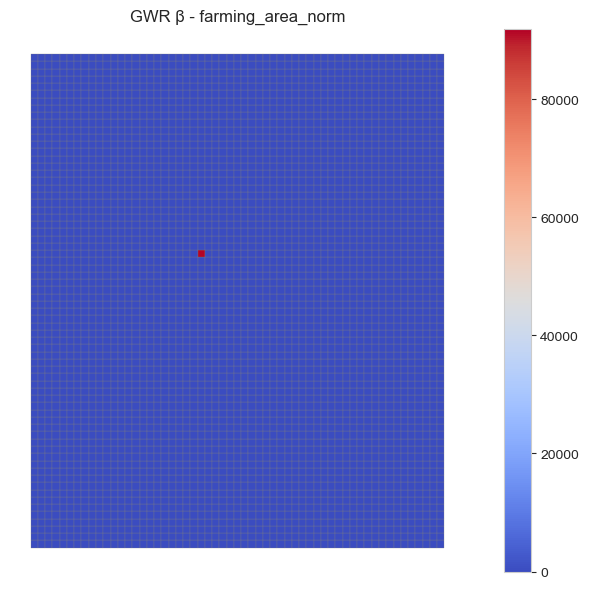

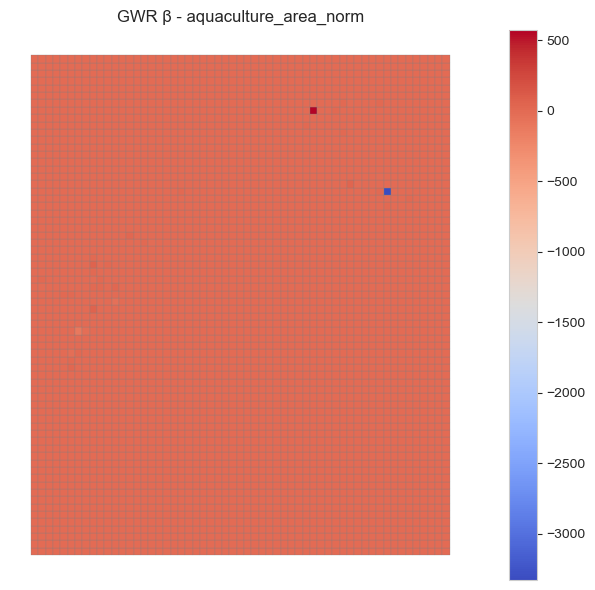

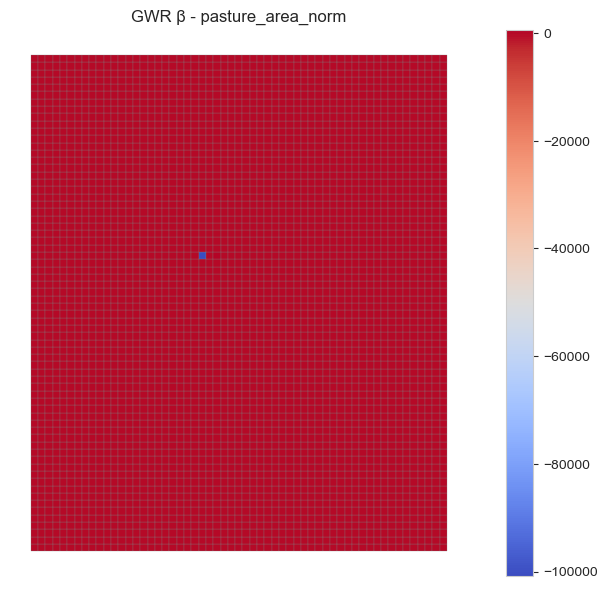

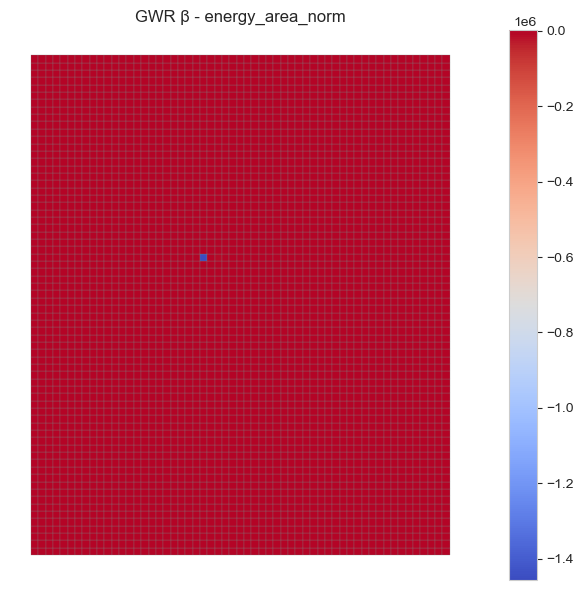

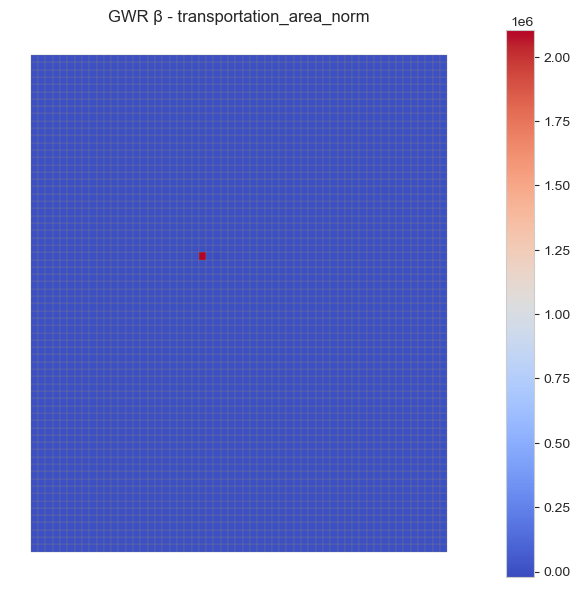

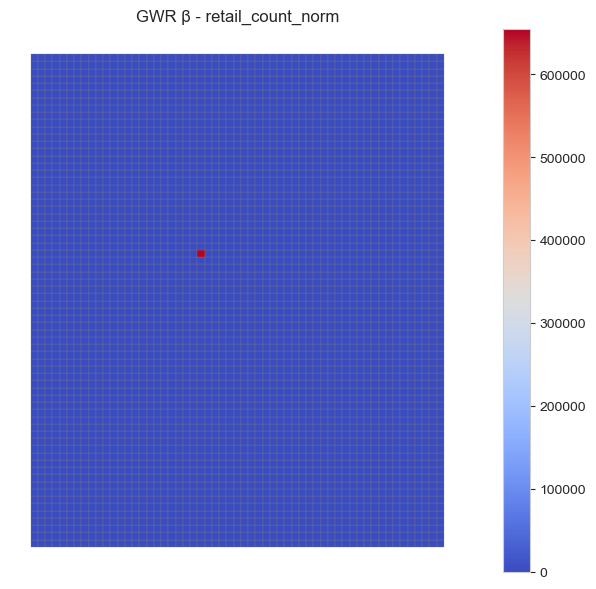

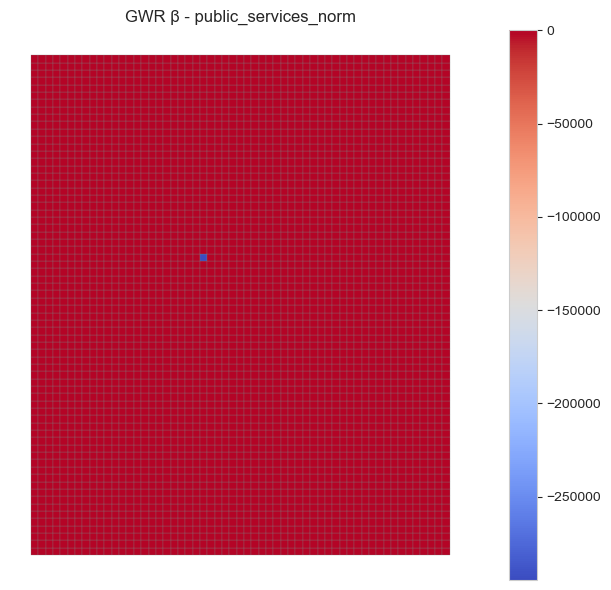

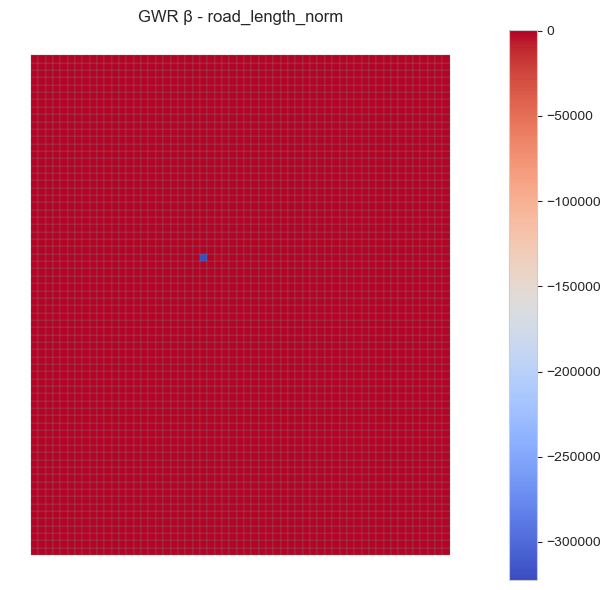

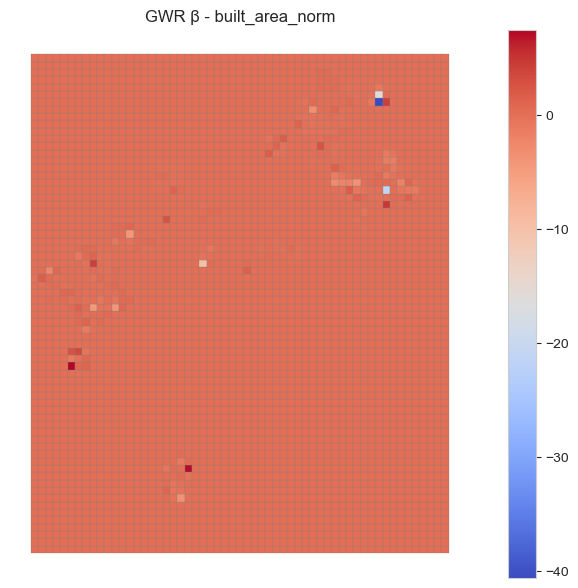

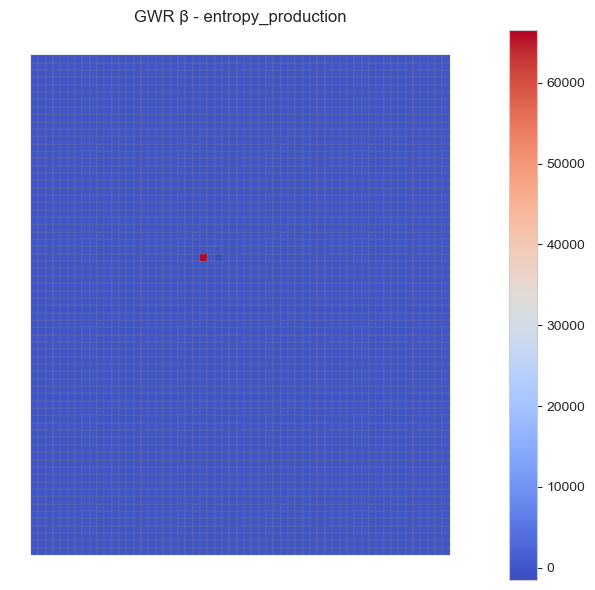

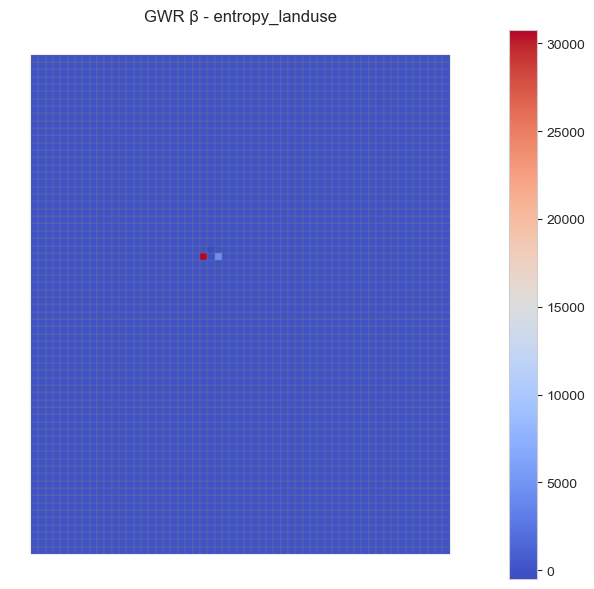

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 假设你已有 gwr_results，X_raw 是变量原始列
coeff_names = ["Intercept"] + list(X_raw.columns)

# 创建新的 GeoDataFrame（patches中变量顺序需与 GWR 输入一致）
patches_gwr = patches.loc[X_raw.index].copy()

# 将 GWR 输出结果写入每个 patch 属性中
for i, var in enumerate(coeff_names):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]

# 添加局部 R²
patches_gwr["R2_local"] = gwr_results.localR2

def plot_gwr_result(gdf, column, title, cmap="coolwarm"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

for var in X_raw.columns:
    plot_gwr_result(patches_gwr, f'beta_{var}', f"GWR β - {var}")